# **I. Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/Othercomputers/내 컴퓨터/라벨이 지정되지 않은 볼륨[F]/교수님/PLS 양돈 농가/데이터/"

In [ ]:
import pandas as pd
import numpy as np

### 원 데이터
odor = pd.read_csv(data_path + "New_data2.csv", encoding="euc-kr")
odor = odor.drop(["yy", "mm", "dd", "farm"], axis = 1)    # 불필요한 변수 제거
odor.rename(columns = {"mm.1" : "mm"}, inplace = True)    # 추후 변수명을 편하게 사용하기 위해
print(odor.shape)
display(odor.head())

(57, 16)


,ou,nh3,h2s,mm,dms,dmds,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
0,300,0.56,145.0,NaN,12.8,NaN,30.60,17.57,2.78,10.80,3.64,7.72,2.84,NaN,NaN,3.00
1,300,0.62,310.0,19.4,462.0,NaN,916.52,1055.96,109.07,977.44,319.49,619.49,30.51,137.81,3.60,10.40
2,448,0.97,90.5,NaN,63.9,NaN,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92
3,2080,1.02,344.0,NaN,13.0,0.63,490.79,570.61,51.09,719.27,168.48,237.64,8.90,60.56,5.55,7.31
4,310,1.18,312.0,NaN,NaN,NaN,404.53,468.03,43.17,573.75,157.22,205.67,9.21,69.90,NaN,5.43


In [ ]:
### 결측값 확인
num_na = odor.isna().sum().sum()


print("NA 개수 :", num_na) #, " ND 개수 :",  num_nd)
na = pd.DataFrame(odor.isna().sum(), columns = ["NA"]).transpose()
na_per = np.round(na/odor.shape[0], 3)
na_per.index = ["NA (%)"]

na_df = pd.concat([na, na_per], axis = 0)
na_df

NA 개수 : 155


,ou,nh3,h2s,mm,dms,dmds,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
NA,0.0,0.0,0.0,31.000,36.000,52.000,0.0,1.000,1.000,1.000,0.0,1.000,2.000,1.000,21.000,8.00
NA (%),0.0,0.0,0.0,0.544,0.632,0.912,0.0,0.018,0.018,0.018,0.0,0.018,0.035,0.018,0.368,0.14


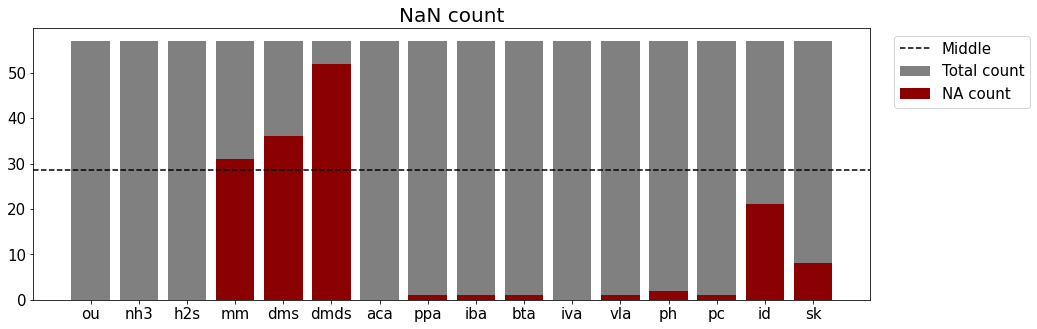

In [ ]:
import matplotlib.pyplot as plt

total = odor.count()+odor.isna().sum()

plt.figure(figsize = (15, 5))
plt.bar(odor.columns, total, label = "Total count", color = "grey")
plt.bar(odor.columns, odor.isna().sum(), label = "NA count", color = "darkred")
plt.axhline(total[0]/2, linestyle = "--", color = "black")
plt.xticks(fontsize = 15) ; plt.yticks(fontsize = 15)
plt.legend(loc = "upper right", labels = ["Middle", "Total count", "NA count"], 
           bbox_to_anchor=(1.2, 1), fontsize = 15)
plt.title("NaN count", fontsize = 20)
plt.show()

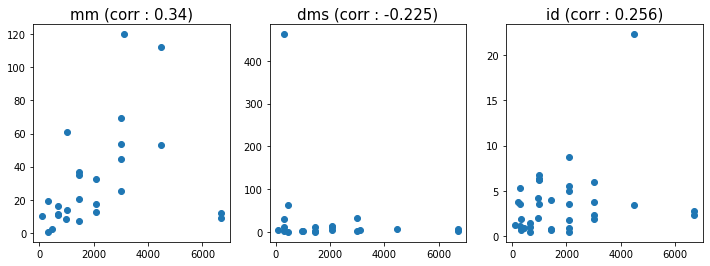

In [ ]:
test_variables = ["mm", "dms", "id"]

plt.figure(figsize = (12, 4))
for i in range(len(test_variables)) :
    test_df = odor.loc[:, ["ou", test_variables[i]]].dropna()
    plt.subplot(1,3,i+1)
    corr = np.round(np.corrcoef(test_df.loc[:, "ou"], test_df.loc[:, test_variables[i]])[0,1], 3)
    plt.scatter(odor.loc[:, "ou"], odor.loc[:, test_variables[i]])
    plt.title(test_variables[i] + " (corr : " + str(corr) + ")", fontsize = 15)
    

plt.show()

In [ ]:
odor2 = odor.drop(columns = ["dmds", "dms"])
print(odor2.shape)
odor2.head(3)

(57, 14)


,ou,nh3,h2s,mm,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
0,300,0.56,145.0,NaN,30.60,17.57,2.78,10.80,3.64,7.72,2.84,NaN,NaN,3.00
1,300,0.62,310.0,19.4,916.52,1055.96,109.07,977.44,319.49,619.49,30.51,137.81,3.60,10.40
2,448,0.97,90.5,NaN,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92


# **II. 평가 지표**

In [ ]:
def R2(true, pred) :
  import numpy as np
  sse = ((np.array(true) - np.array(pred))**2).sum()
  ssr = ((np.array(pred) - np.mean(true))**2).sum()
  sst = ((np.array(true) - np.mean(true))**2).sum()
  # r2 = 1 - (sse/sst)
  r2 = ssr/sst
  return np.round(r2, 3)

def MAPE(true, pred) :
  import numpy as np
  mape = np.mean(np.abs((np.array(true) - np.array(pred)) / np.array(true))) * 100
  return np.round(mape, 3)

def RMSE(true, pred) :
  import numpy as np
  mse = np.mean((np.array(true) - np.array(pred))**2)
  rmse = np.sqrt(mse)
  return np.round(rmse, 3)

# **III. Function**

In [ ]:
def Odor(data, missing, Variable, Model) :

  import pandas as pd
  import numpy as np
  from sklearn.linear_model import BayesianRidge
  from sklearn.tree import DecisionTreeRegressor
  from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
  from sklearn.neighbors import KNeighborsRegressor
  from sklearn.experimental import enable_iterative_imputer
  from sklearn.impute import IterativeImputer
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler
  from tqdm.notebook import tqdm
  from sklearn import model_selection
  from sklearn.model_selection import RepeatedKFold
  from sklearn.metrics import mean_squared_error
  from sklearn.cross_decomposition import PLSRegression
  from sklearn.decomposition import PCA
  from itertools import accumulate
  from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
  from xgboost import XGBRFRegressor
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense
  import tensorflow as tf
  from sklearn.neural_network import MLPRegressor
  import statsmodels.api as sm

  # """< Missing Value and Data set >"""
  if missing == "Bayesian Rdige" :
    estimators = BayesianRidge()
  elif missing == "Decision Tree Regressor" :
    estimators = DecisionTreeRegressor(max_features = 'sqrt', random_state = 99)
  elif missing == "Extra Tree Regressor" :
    estimators = ExtraTreesRegressor(n_estimators = 10, random_state = 99)
  elif missing == "KNN Regressor" :
    estimators = KNeighborsRegressor(n_neighbors = 15)

  imp = IterativeImputer(max_iter = 100000, estimator = estimators, min_value = 0, random_state = 99)

  imp_data = pd.DataFrame(imp.fit_transform(data), columns = data.columns)

  pred_list = []  ; pls_list = []  ; pca_list = []  ; alpha_list = []
  for i in tqdm(range(imp_data.shape[0])) :
    new_data = imp_data.drop(index = i)
    sel = pd.DataFrame(imp_data.iloc[i, :]).T
    new_data = pd.concat([new_data, sel], axis = 0)


    # """< Data Split and Standard >"""
    train_X, test_X, train_y, test_y = train_test_split(new_data.iloc[:, 1:], new_data.loc[:, "ou"], 
                                                        test_size = 1/new_data.shape[0], shuffle = False, 
                                                        random_state = 99)
    X_std = StandardScaler().fit(train_X)
    st_train_X = pd.DataFrame(X_std.transform(train_X), columns = train_X.columns)
    st_test_X = pd.DataFrame(X_std.transform(test_X), columns = test_X.columns)

    train_y2 = np.array(train_y).reshape(-1, 1)
    y_std = StandardScaler().fit(train_y2)
    st_train_y = pd.DataFrame(y_std.transform(train_y2), columns = [train_y.name])


    # """< Variable Extraction and Selection >"""
    if Variable == "None" :
      new_train_X = st_train_X
      new_test_X = st_test_X

    elif Variable == "PLS" :
      cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 99)
      mse = []
      for i in np.arange(1, st_train_X.shape[1]+1) :
          pls = PLSRegression(n_components = i)
          score = -1*model_selection.cross_val_score(pls, st_train_X, st_train_y, cv = cv,
                                                    scoring = 'neg_mean_squared_error').mean()
          mse.append(score)
      pls_bc = mse.index(min(mse)) + 1     # Best Component

      pls_fit = PLSRegression(n_components = pls_bc).fit(st_train_X, st_train_y)
      new_train_X = pd.DataFrame(pls_fit.transform(st_train_X), columns = ["comp " + str(i+1) for i in range(pls_bc)])
      new_test_X = pd.DataFrame(pls_fit.transform(st_test_X), columns = ["comp " + str(i+1) for i in range(pls_bc)])

    elif Variable == "PCA" :
      pca = PCA(n_components = st_train_X.shape[1], random_state = 99).fit(st_train_X)
      cum_var = list(accumulate(pca.explained_variance_ratio_)) 
      pca_idx = np.where(np.array(cum_var) > 0.99)[0][0] + 1

      pca = PCA(n_components = pca_idx, random_state = 99).fit(st_train_X)
      new_train_X = pd.DataFrame(pca.transform(st_train_X), columns = ["comp" + str(i) for i in range(pca_idx)])
      new_test_X = pd.DataFrame(pca.transform(st_test_X), columns = ["comp" + str(i) for i in range(pca_idx)])

    elif Variable == "Ridge" : 
      vs_method = RidgeCV(alphas = [i*0.01 for i in range(1, 100)]).fit(st_train_X, st_train_y)
      del_columns = st_train_X.columns[np.where(abs(vs_method.coef_[0]) < 0.05)]
      new_train_X = st_train_X.drop(columns = del_columns)
      new_test_X = st_test_X.drop(columns = del_columns)
      if len(del_columns) == len(st_train_X.columns) :
        new_train_X = st_train_X
        new_test_X = st_test_X

    elif Variable == "Lasso" : 
      vs_method = LassoCV(alphas = [i*0.01 for i in range(1, 100)], random_state = 99).fit(st_train_X, np.ravel(st_train_y))
      del_columns = st_train_X.columns[np.where(abs(vs_method.coef_) == 0)]
      new_train_X = st_train_X.drop(columns = del_columns)
      new_test_X = st_test_X.drop(columns = del_columns)
      if len(del_columns) == len(st_train_X.columns) :
        new_train_X = st_train_X
        new_test_X = st_test_X

    elif Variable == "Elastic net" : 
      vs_method = ElasticNetCV(l1_ratio = [i*0.01 for i in range(1, 100)], alphas = [i*0.01 for i in range(1, 100)],
                              random_state = 99).fit(st_train_X, np.ravel(st_train_y))
      del_columns = st_train_X.columns[np.where(abs(vs_method.coef_) == 0)]
      new_train_X = st_train_X.drop(columns = del_columns)
      new_test_X = st_test_X.drop(columns = del_columns)     
      if len(del_columns) == len(st_train_X.columns) :
        new_train_X = st_train_X
        new_test_X = st_test_X


    # """< Model >"""
    if Model == "Regression" :
      new_train_X = sm.add_constant(new_train_X, has_constant = "add")
      new_test_X = sm.add_constant(new_test_X, has_constant = "add")
      model = sm.OLS(np.ravel(st_train_y), new_train_X).fit()

    elif Model == "Random Forest" :
      model = RandomForestRegressor(random_state = 99).fit(new_train_X, np.ravel(st_train_y))

    elif Model == "Extra Tree" :
      model = ExtraTreesRegressor(random_state = 99).fit(new_train_X, np.ravel(st_train_y))

    elif Model == "XGboost" :
      model = XGBRFRegressor(random_state = 99).fit(new_train_X, np.ravel(st_train_y))

    elif Model == "ANN" :
      tf.random.set_seed(99)
      model = Sequential()
      model.add(Dense(10, input_dim = new_train_X.shape[1], activation = "relu"))
      model.add(Dense(1))
      model.compile(loss = "mean_squared_error",            # 손실함수
                    optimizer = "adam",                     # 옵티마이저 설정
                    metrics = ["mean_squared_error"])       # 모형 평가 지표
      model.fit(new_train_X, np.ravel(st_train_y), epochs = 30, verbose = 0)

    elif Model == "MLP1" :
      model = MLPRegressor(hidden_layer_sizes = 10, max_iter = 10000, random_state = 99).fit(new_train_X, np.ravel(st_train_y))

    elif Model == "MLP2" :
      model = MLPRegressor(hidden_layer_sizes = (7,7), max_iter = 10000, random_state = 99).fit(new_train_X, np.ravel(st_train_y))


    # """< Predict >"""
    if Model == "ANN" :
      pred = y_std.inverse_transform(model.predict(new_test_X))[0][0]
    else :
      pred = y_std.inverse_transform(model.predict(new_test_X))[0]

    # """< Result Saving >"""
    pred_list.append(np.round(pred, 3))
    # pls_list.append(pls_bc)
    # pca_list.append(pca_bc)
    # alpha_list.append(vs_method.alpha_)

  return {"prediction" : pred_list} #, "PLS components" : pls_list, "PCA components" : pca_list, "alpha" : alpha_list}

# **IV. Result**

In [ ]:
Missings = ["Bayesian Rdige", "Decision Tree Regressor", "Extra Tree Regressor", "KNN Regressor"]
Variables = ["None", "PLS", "PCA", "Ridge", "Lasso", "Elastic net"]
Models = ["Regression", "Random Forest", "Extra Tree", "ANN", "MLP1", "MLP2"]

In [ ]:
from tqdm.notebook import tqdm

r2_list = []
rmse_list = []
mape_list = []
method = []
preds_df = pd.DataFrame(index = range(0, 57))

for i in tqdm(range(len(Missings))) :
  for j in range(len(Variables)) :
    for k in range(len(Models)) :
      result = Odor(data = odor2, missing = Missings[i], Variable = Variables[j], Model = Models[k])

      pred = result["prediction"]
      pred_df = pd.DataFrame(pred, columns = [Missings[i] + "_" + Variables[j] + "_" + Models[k]])
      preds_df = pd.concat([preds_df, pred_df], axis = 1)

      method.append(Missings[i] + "_" +Variables[j] + "_" + Models[k])
#       r2_list.append(R2(odor2.loc[:, "ou"], pred))
#       rmse_list.append(RMSE(odor2.loc[:, "ou"], pred))
#       mape_list.append(MAPE(odor2.loc[:, "ou"], pred))

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

In [ ]:
display(preds_df.head(3))
display(preds_df.tail(3))
print(preds_df.shape)
preds_df.to_csv(data_path + "Prediction results2.csv", index = False)

In [ ]:
results = pd.read_csv(data_path + "Prediction results2.csv")
display(results.head(3))

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import r2_score
actual = odor2.loc[:,"ou"]
r2_cal_list = []
r2_sk_list = []
r2_ols_list = []
rmse_list = []
mape_list = []

for i in range(results.shape[1]) :
    r2_cal_list.append(R2(actual, results.iloc[:, i]))
    r2_sk_list.append(np.round(r2_score(actual, results.iloc[:, i]), 3))
    const_pred_list = sm.add_constant(results.iloc[:, i], has_constant = "add")
    ols = sm.OLS(actual, const_pred_list).fit()
    r2_ols_list.append(np.round(ols.rsquared, 3))
    rmse_list.append(RMSE(actual, results.iloc[:, i]))
    mape_list.append(MAPE(actual, results.iloc[:, i]))
    
print(len(r2_cal_list), len(r2_sk_list), len(r2_ols_list), len(rmse_list), len(mape_list))
print(r2_cal_list[:5], r2_sk_list[:5], r2_ols_list[:5],rmse_list[:5], mape_list[:5])

In [ ]:
r2_ols_df = pd.DataFrame(r2_ols_list, columns = ["R2 (ols)"], index = results.columns)
sort_r2_ols_df = r2_ols_df.sort_values(by = ["R2 (ols)"], ascending = False)

rmse_df = pd.DataFrame(rmse_list, columns = ["R2 (rmse)"], index = results.columns)
sort_rmse_df = rmse_df.sort_values(by = ["R2 (rmse)"])

mape_df = pd.DataFrame(mape_list, columns = ["R2 (mape)"], index = results.columns)
sort_mape_df = mape_df.sort_values(by = ["R2 (mape)"])

# display(sort_r2_ols_df.head(3))
# display(sort_rmse_df.head(3))
# display(sort_mape_df.head(3))

In [ ]:
rank = 15
best_models_df = pd.DataFrame([sort_r2_ols_df.index[:rank], sort_rmse_df.index[:rank], sort_mape_df.index[:rank]],
                               index = ["R2 (ols)", "RMSE", "MAPE"]).T
best_models_df

In [ ]:
best_models = set(best_models_df.iloc[:, 0]) & set(best_models_df.iloc[:, 1]) & set(best_models_df.iloc[:, 2])
best_models

In [ ]:
def draw_color_at_nan(x,color):
    if x in best_models:
        color = f'background-color:{color}'
        return color
    else:
        return ''
    
best_models_df.style.applymap(draw_color_at_nan, color = '#67c5a4')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 15))

plt.subplot(5, 1, 1)
plt.plot(r2_cal_list, color = "black", marker = "o")
plt.title("R2 (SSR/SST)", fontsize = 20)

plt.subplot(5, 1, 2)
plt.plot(r2_sk_list, color = "black", marker = "o")
plt.title("R2 (Sklearn)", fontsize = 20)

plt.subplot(5, 1, 3)
plt.plot(r2_ols_list, color = "black", marker = "o")
plt.title("R2 (Ols)", fontsize = 20)

plt.subplot(5, 1, 4)
plt.plot(rmse_list, color = "black", marker = "o")
plt.title("RMSE", fontsize = 20)

plt.subplot(5, 1, 5)
plt.plot(mape_list, color = "black", marker = "o")
plt.title("MAPE", fontsize = 20)

plt.tight_layout()
plt.show()

In [ ]:
best_results = results.loc[:, best_models]
print(best_results.shape)
display(best_results.head(3))

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

plt.figure(figsize = (21, 14))
for i in range(best_results.shape[1]) :
    const_pred_list = sm.add_constant(best_results.iloc[:, i], has_constant = "add")
    pred_ols = sm.OLS(actual, const_pred_list).fit()
    linear_x = range(0, 8000, 1000)
    linear_y = pred_ols.params[0] + pred_ols.params[1]*linear_x

    plt.subplot(2, 3, i+1)
    plt.scatter(actual, best_results.iloc[:, i])
    plt.plot(linear_x, linear_y, color = "darkred")
    plt.xlim(-2000, 7000) ; plt.ylim(-2000, 7000)
    plt.plot([0, 7000], [0, 7000], color = "black")
    plt.axhline(0, color = "grey", linestyle = "--")
    plt.axvline(0, color = "grey", linestyle = "--")
    plt.xlabel("Observed", fontsize = 15)  ; plt.ylabel("predict", fontsize = 15)
    plt.text(-1700,6500, best_results.columns[i], 
            fontsize = 15, weight = "bold",
            bbox = dict(facecolor = 'ivory', edgecolor = 'black', boxstyle = 'round'))
    plt.text(-1700, 4500, 
            "y = " + str(np.round(pred_ols.params[0], 3)) + "+" + str(np.round(pred_ols.params[1], 3)) + "x" +
            "\nR2 (OLS) : " + str(np.round(pred_ols.rsquared, 3)) +
            "\nR2 (SSR/SST) : " + str(R2(actual, best_results.iloc[:, i])) +
            "\nRMSE : " + str(RMSE(actual, best_results.iloc[:, i])) +
            "\nMAPE : " + str(MAPE(actual, best_results.iloc[:, i])),
            fontsize = 15,
            bbox = dict(facecolor = 'white', edgecolor = 'none', boxstyle = 'round'))

plt.tight_layout()
plt.show()